In [1]:
# 🏃‍♂️ Player Off-Frame Prediction with LSTM (YOLO Tracking Simulation)

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
# --- CONFIGURATION ---
SEQ_LEN = 10         # Number of past positions to feed the LSTM
PREDICT_STEPS = 10   # Number of future positions to predict
INPUT_SIZE = 2       # (x, y) coordinates
HIDDEN_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
# --- SIMULATE PLAYER TRACKING DATA ---
def simulate_player_movement(total_frames=50):
    # Simulates a player running diagonally across a field
    trajectory = []
    x, y = 50, 50
    for _ in range(total_frames):
        dx = random.uniform(4.0, 6.0)
        dy = random.uniform(1.0, 3.0)
        x += dx
        y += dy
        trajectory.append([x, y])
    return trajectory


In [5]:
# --- LSTM MODEL ---
class PositionPredictor(nn.Module):
    def __init__(self):
        super(PositionPredictor, self).__init__()
        self.lstm = nn.LSTM(INPUT_SIZE, HIDDEN_SIZE, batch_first=True)
        self.fc = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # predict next position

In [6]:
# --- GENERATE TRAINING DATA FROM SIMULATED MOVEMENT ---
def generate_training_data(traj, seq_len=SEQ_LEN):
    X, Y = [], []
    for i in range(len(traj) - seq_len - 1):
        X.append(traj[i:i+seq_len])  # Sequence of length seq_len
        Y.append(traj[i+seq_len])   # The next position after the sequence
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [7]:
# --- TRAINING ---
full_trajectory = simulate_player_movement(100)
train_X, train_Y = generate_training_data(full_trajectory)

In [8]:
# --- MODEL INITIALIZATION ---
model = PositionPredictor().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
# --- TRAIN THE MODEL ---
model.train()
for epoch in range(200):
    inputs = train_X.to(DEVICE)
    targets = train_Y.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 50, Loss: 75040.5938
Epoch 100, Loss: 72811.1484
Epoch 150, Loss: 71116.1172
Epoch 200, Loss: 69684.8438


In [10]:
# --- SIMULATE TRACKING + PREDICTION WHEN OFF-FRAME ---
tracked = full_trajectory[:-PREDICT_STEPS]
offscreen_seed = full_trajectory[-SEQ_LEN - PREDICT_STEPS:-PREDICT_STEPS]

predicted_positions = []
model.eval()
with torch.no_grad():
    current_input = torch.tensor([offscreen_seed], dtype=torch.float32).to(DEVICE)
    for _ in range(PREDICT_STEPS):
        next_pos = model(current_input)
        predicted_positions.append(next_pos.squeeze().cpu().numpy())
        current_input = torch.cat((current_input[:, 1:, :], next_pos.unsqueeze(1)), dim=1)


In [11]:

# --- PLOT RESULTS ---
tracked_np = np.array(tracked)
predicted_np = np.array(predicted_positions)

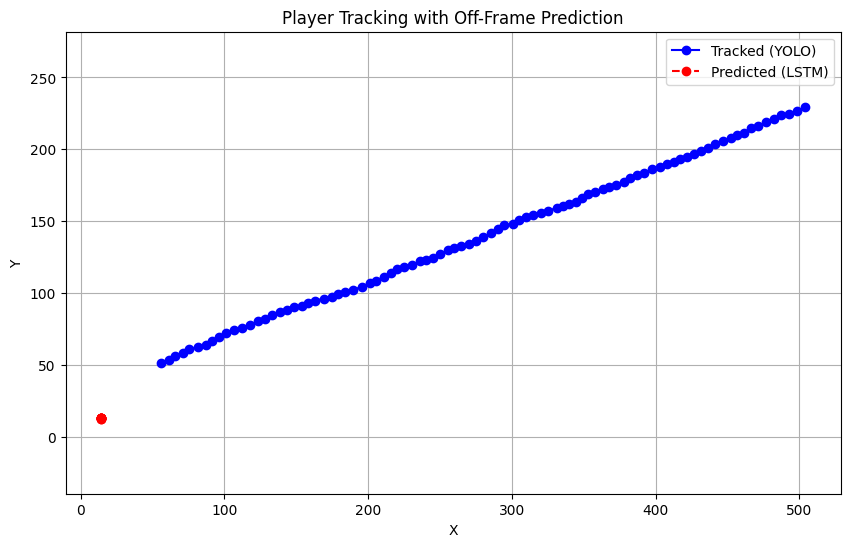

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(tracked_np[:, 0], tracked_np[:, 1], 'bo-', label="Tracked (YOLO)")
plt.plot(predicted_np[:, 0], predicted_np[:, 1], 'ro--', label="Predicted (LSTM)")
plt.title("Player Tracking with Off-Frame Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()